In [138]:
import numpy as np
import matplotlib.pyplot as plt
from jit_wrap import save_jit_model
from local_mdn import get_argmax_mu
import os

data_train = np.load('data2/noisy_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


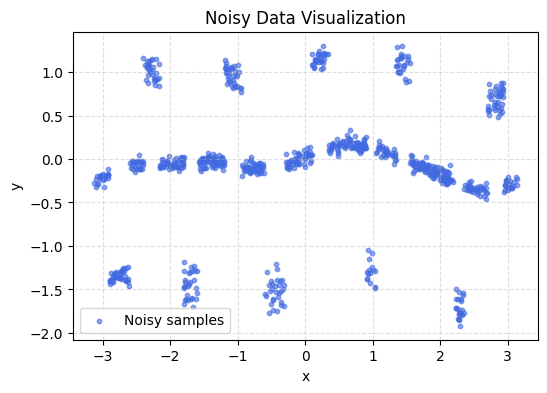

In [139]:
x_train_in = data_train["x"]
y_train_in = data_train["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=10, alpha=0.6, color="royalblue", label="Noisy samples")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


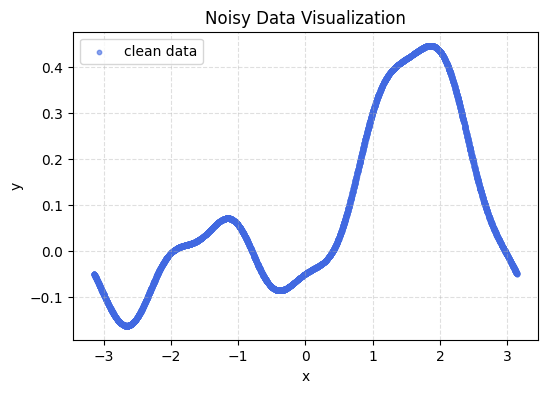

In [140]:
data_test = np.load('data1/clean_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

x_test = data_test["x"]
y_test = data_test["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_test, y_test, s=10, alpha=0.6, color="royalblue", label="clean data")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [141]:
import sys, torch, os, site
print("Python exe:", sys.executable)
print("torch file:", getattr(torch, "__file__", None))
print("has torch.version? ->", hasattr(torch, "version"))
print("User-site:", site.getusersitepackages())

Python exe: c:\Program Files\Python311\python.exe
torch file: C:\Users\mnhat\AppData\Roaming\Python\Python311\site-packages\torch\__init__.py
has torch.version? -> True
User-site: C:\Users\mnhat\AppData\Roaming\Python\Python311\site-packages


In [142]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
print("cuda in wheel:", torch.version.cuda)
from util import (
    get_torch_size_string,
    print_model_parameters,
    th2np,
)
from local_mdn import (
    MixtureDensityNetwork,
    gmm_forward,
    eval_mdn_1d,
)

2.5.1+cu121
cuda in wheel: 12.1


In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.version.cuda

'12.1'

In [144]:
# when you build the model (keep k=5 if you like)
mdn = MixtureDensityNetwork(
    name='mdn',
    x_dim=1, y_dim=1, k=5,
    h_dim_list=[64,64],
    actv=nn.SiLU(),
    sig_max=10.0,  # <= tighten
    mu_min=-0.02,      # <= widen (in normalized units)
    mu_max=+0.02,
    p_drop=0.0, use_bn=False,
).to(device)
mdn.init_param()
optm = torch.optim.Adam(mdn.parameters(), lr=3.2e-5, eps=1e-4, weight_decay=1e-4)
schd = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=0.9999)

In [145]:
n_train = 800
x_train = torch.from_numpy(x_train_in).to(device)
y_train = torch.from_numpy(y_train_in).to(device)

In [146]:
max_iter,batch_size,print_every,plot_every = 2e4,64,1000,5000
print ("max_iter:[%d] batch_size:[%d] print_every:[%d] plot_every:[%d]"%
      (max_iter,batch_size,print_every,plot_every))

max_iter:[20000] batch_size:[64] print_every:[1000] plot_every:[5000]


In [147]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()

Start training


MixtureDensityNetwork(
  (actv): SiLU()
  (net): Sequential(
    (linear_00): Linear(in_features=1, out_features=64, bias=True)
    (silu_01): SiLU()
    (dropout1d_02): Dropout1d(p=0.0, inplace=False)
    (linear_03): Linear(in_features=64, out_features=64, bias=True)
    (silu_04): SiLU()
    (dropout1d_05): Dropout1d(p=0.0, inplace=False)
    (mixturesofgaussianlayer_06): MixturesOfGaussianLayer(
      (fc_pi): Linear(in_features=64, out_features=5, bias=True)
      (fc_mu): Linear(in_features=64, out_features=5, bias=True)
      (fc_sigma): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

Start training
[   0/20000] loss:[3.142]


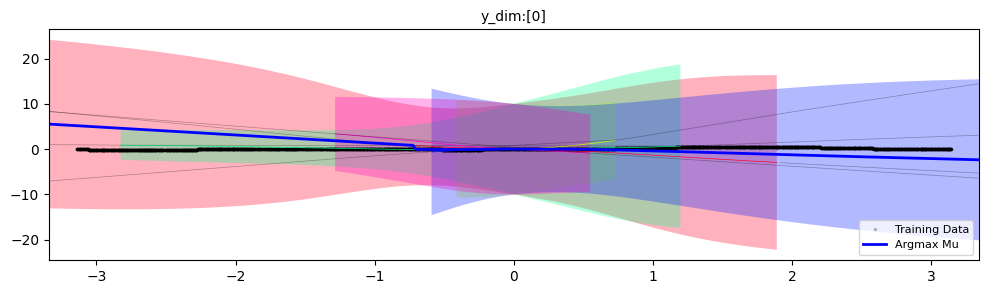

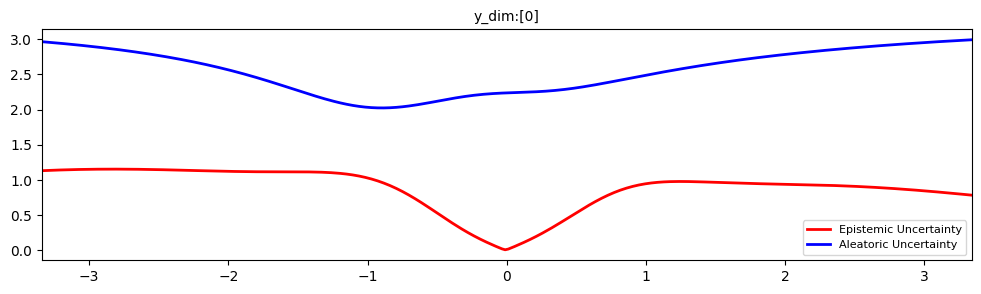

[1000/20000] loss:[1.130]
[2000/20000] loss:[1.194]
[3000/20000] loss:[1.292]
[4000/20000] loss:[1.227]
[5000/20000] loss:[1.202]


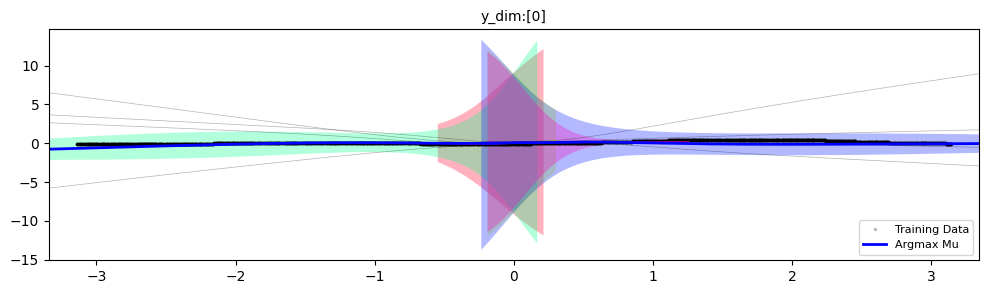

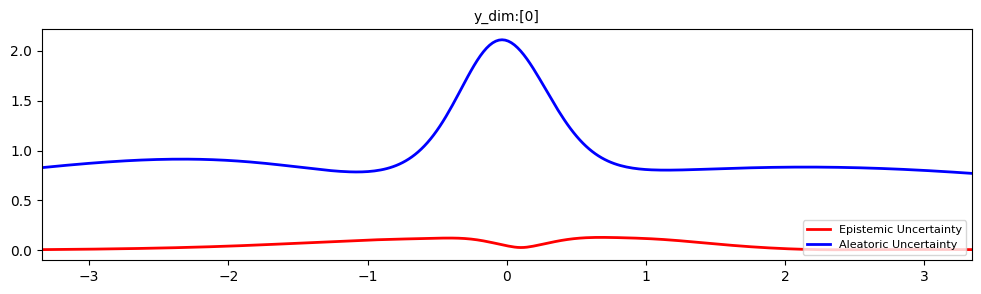

[6000/20000] loss:[1.259]
[7000/20000] loss:[1.181]
[8000/20000] loss:[1.130]
[9000/20000] loss:[1.086]
[10000/20000] loss:[1.005]


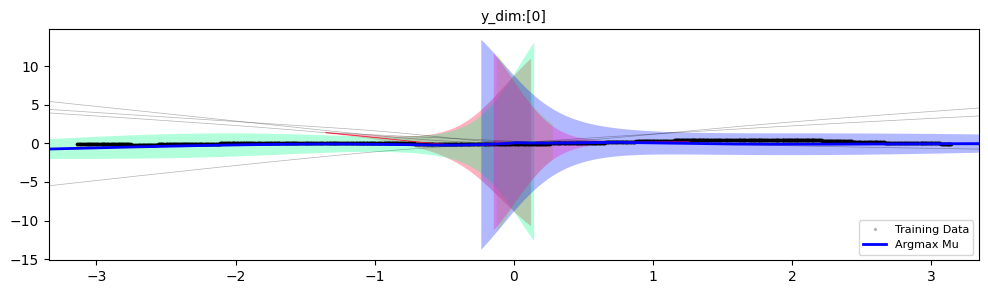

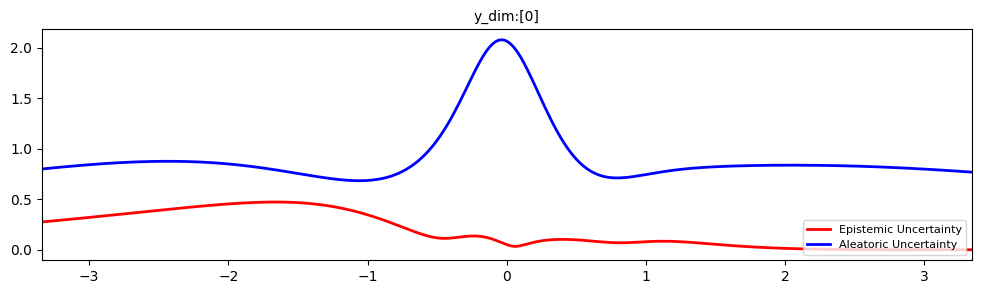

[11000/20000] loss:[1.014]
[12000/20000] loss:[1.158]
[13000/20000] loss:[1.045]
[14000/20000] loss:[1.114]
[15000/20000] loss:[1.195]


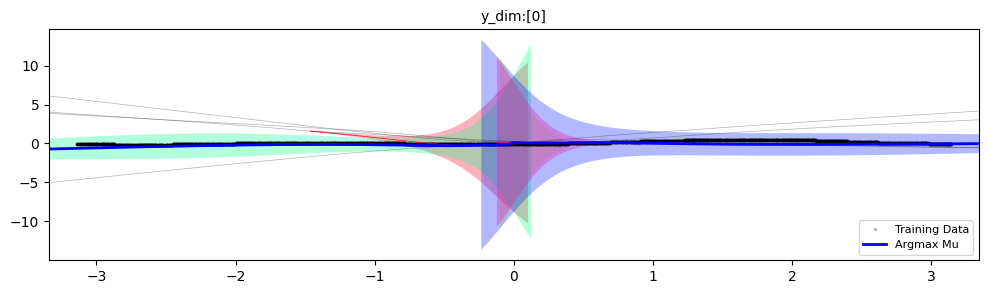

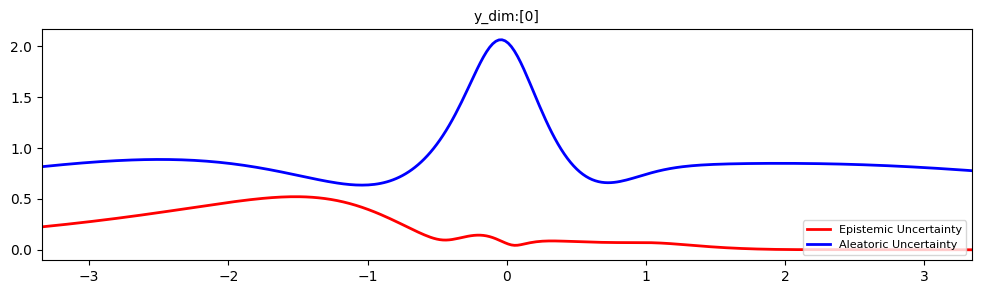

[16000/20000] loss:[0.979]
[17000/20000] loss:[0.725]
[18000/20000] loss:[1.236]
[19000/20000] loss:[1.091]
[19999/20000] loss:[1.100]


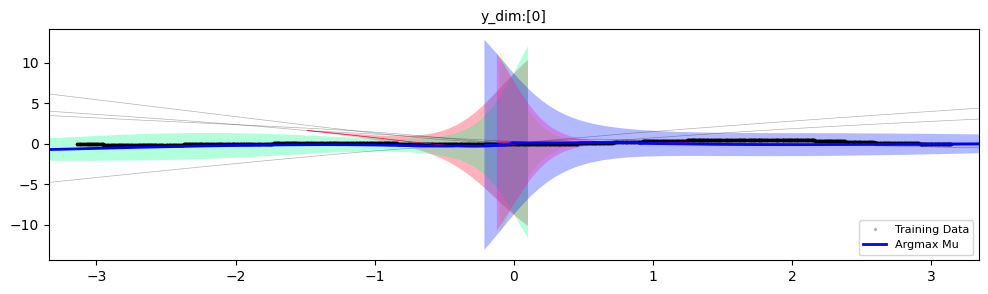

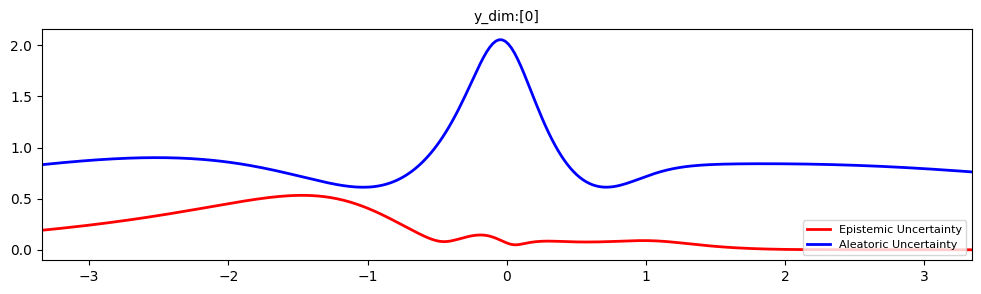

Done.


In [148]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()
x_train = torch.Tensor(x_train_in).to(device)
y_train = torch.Tensor(y_train_in).to(device)

for it in range(int(max_iter)):
    batch_idx = np.random.permutation(n_train)[:batch_size]
    x_batch,y_batch = x_train[batch_idx],y_train[batch_idx]

    # Update
    mdn.zero_grad()
    pi_batch,mu_batch,sigma_batch = mdn.forward(x_batch)
    gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
    loss = torch.mean(gmm_out['nlls']) + 0.1*F.mse_loss(y_batch,gmm_out['argmax_mu'])
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if ((it%print_every)==0) or (it==(max_iter-1)):
        print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))

    # Plot
    if ((it%plot_every)==0) or (it==(max_iter-1)):
        eval_mdn_1d(mdn,x_test,y_test,figsize=(12,3),device=device)
print("Done.")
    
    # ... your print/plot stay unchanged ...




Loading validation data 'validation_data.npz'...
Validation data loaded successfully.


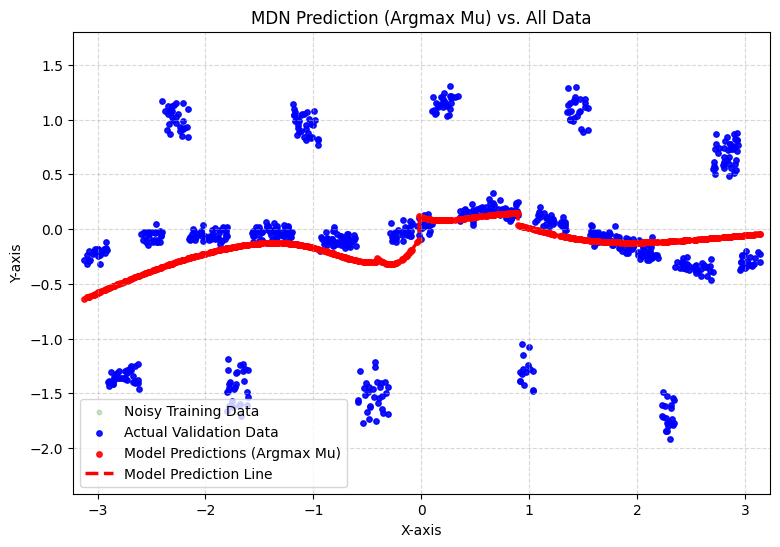

In [149]:
print("Loading validation data 'validation_data.npz'...")
val_data = np.load('./data2/noisy_data.npz')
x_val = val_data['x']
y_val = val_data['y']
print("Validation data loaded successfully.")
    
# Prepare validation data (reshape and convert to tensor)
# ...existing code...
# Prepare validation data (reshape and convert to tensor)
if x_val.ndim == 1: x_val = x_val.reshape(-1, 1)
if y_val.ndim == 1: y_val = y_val.reshape(-1, 1)

# send validation inputs to the same device as the model
x_val_tensor = torch.tensor(x_val).float().to(device)

# Set model to evaluation mode
mdn.eval()

# Get model predictions for the validation set
with torch.no_grad():
    pi_val, mu_val, sigma_val = mdn(x_val_tensor)
    y_val_pred_tensor = get_argmax_mu(pi_val, mu_val)

# Convert tensors to NumPy (ensure CPU)
y_val_pred_np = th2np(y_val_pred_tensor)
x_val_np = th2np(x_val_tensor)
# if x_train/y_train are torch tensors, convert them for plotting:
x_train_np = th2np(x_train) if isinstance(x_train, torch.Tensor) else x_train
y_train_np = th2np(y_train) if isinstance(y_train, torch.Tensor) else y_train
y_val_np = y_val  # already numpy

# plotting ...
plt.figure(figsize=(9, 6))
plt.scatter(x_train_np, y_train_np, color='green', label='Noisy Training Data', s=10, alpha=0.2)
plt.scatter(x_val_np, y_val_np, color='blue', label='Actual Validation Data', s=15, alpha=0.9)
plt.scatter(x_val_np, y_val_pred_np, color='red', label='Model Predictions (Argmax Mu)', s=15, alpha=0.9)
sort_indices = np.argsort(x_val_np.squeeze())
plt.plot(x_val_np[sort_indices], y_val_pred_np[sort_indices], color='red', linestyle='--', linewidth=2.5, label='Model Prediction Line')
plt.title('MDN Prediction (Argmax Mu) vs. All Data')
plt.xlabel('X-axis'); plt.ylabel('Y-axis')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(y_train_np.min() - 0.5, y_train_np.max() + 0.5)
plt.xlim(x_train_np.min() - 0.1, x_train_np.max() + 0.1)
plt.show()
# ...existing code...

In [153]:
# exit()

print("\n--- Saving JIT Model ---")
# Ensure the 'model/' directory exists (relative to notebook)
os.makedirs('model', exist_ok=True)

# Set model to evaluation mode and move to CPU before saving
mdn.eval()
mdn.cpu()

JIT_MODEL_PATH = "model/2025021848.pth"
save_jit_model(mdn, JIT_MODEL_PATH)


--- Saving JIT Model ---
Wrapping model for JIT tracing...
JIT-traced model saved successfully to model/2025021848.pth
